In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset
from hmpai.data import SAT1_STAGES_ACCURACY, COMMON_STAGES
from hmpai.visualization import plot_confusion_matrix
from hmpai.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
from mne.io import read_info
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
set_global_seed(42)
data_path_sat1 = Path("../data/sat1/stage_data_100hz.nc")
dataset_sat1 = xr.load_dataset(data_path_sat1)

In [3]:
# Split before merging to ensure equal participant distribution across datasets and normalization within dataset
shape_topological = False
train_data_sat1, val_data_sat1, test_data_sat1 = split_data_on_participants(
    dataset_sat1, 60, norm_min1_to_1
)

In [4]:
chk_path = Path("../models/gru100/checkpoint.pt")
checkpoint = load_model(chk_path)

model_kwargs = {
    "n_channels": len(train_data_sat1.channels),
    "n_samples": len(train_data_sat1.samples),
    "n_classes": len(train_data_sat1.labels),
}
model = SAT1GRU(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:
train_dataset = SAT1Dataset(
    train_data_sat1, shape_topological=shape_topological, labels=SAT1_STAGES_ACCURACY
)
val_dataset = SAT1Dataset(
    val_data_sat1, shape_topological=shape_topological, labels=SAT1_STAGES_ACCURACY
)
test_dataset = SAT1Dataset(
    test_data_sat1, shape_topological=shape_topological, labels=SAT1_STAGES_ACCURACY
)

In [6]:
test_loader = DataLoader(
    test_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

In [11]:
torch.set_printoptions(sci_mode=False)
proba_list = []
model = model.eval()
min_length = 1
for batch in test_loader:
    # print(batch[0].shape)
    # (batch_size, 300, 20)
    for epoch, true in zip(batch[0], batch[1]):
        proba_epoch = np.full(
            (
                len(test_data_sat1.samples),
                len(test_data_sat1.samples),
                len(test_data_sat1.labels),
            ),
            np.nan,
        )
        # Create batch of every combination of start/length
        # Epoch ends at first -1 in truth labels
        end_idx = (true == -1).nonzero().squeeze()[0]
        print(end_idx)
        print(true)
        sub_batch = []
        for start in range(end_idx):
            slices = [
                epoch[start : start + length]
                for length in range(min_length, end_idx - start)
            ]
            if len(slices) == 0:
                break
            # for slice in slices[0:5]:
            #     print(slice[:,0])
            padded = [
                torch.nn.functional.pad(
                    slice,
                    (0, 0, 0, len(test_data_sat1.samples) - slice.size(0)),
                    value=MASKING_VALUE,
                )
                for slice in slices
            ]
            # for slice in padded[:-1]:
            #     print(slice)
            # print(len(padded))
            padded = torch.stack(padded).to(DEVICE)
            pred = model(padded)
            pred = torch.nn.Softmax(dim=1)(pred)
            # print(pred.shape)
            # print(start + min_length, start + min_length + pred.size(0))
            proba_epoch[
                start + min_length : start + min_length + pred.size(0), start
            ] = (pred.detach().cpu().numpy())
        break
    break

tensor(35)
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,
         1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  4,  4,  4, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1])


/tmp/ipykernel_10839/424088146.py:13: RuntimeWarning: Mean of empty slice
  mean_proba = np.nanmean(mean_data, axis=0)


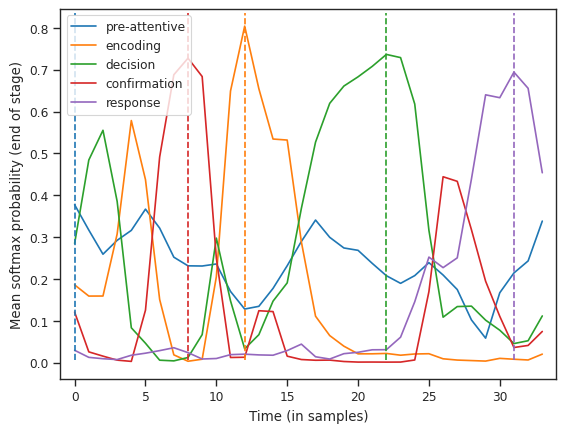

In [15]:
colors = sns.color_palette(None, n_colors=len(SAT1_STAGES_ACCURACY))
sns.set_style("ticks")
sns.set_context("paper")

nan_idx = end_idx
mean_data = np.copy(proba_epoch)

# Remove all with 'certainty' under 0.1
# mean_data[mean_data < 0.1] = np.nan

# mean_proba = (np.nanmean(mean_data, axis=0) + np.nanmean(mean_data, axis=1)) / 2

mean_proba = np.nanmean(mean_data, axis=0)


plt.plot(mean_proba)
plt.xlim(-1, nan_idx - 1)
plt.ylabel("Mean softmax probability (end of stage)")
plt.xlabel("Time (in samples)")
for i in range(proba_epoch.shape[2]):
    subset = mean_proba[:, i]

    if np.nanmax(subset) > 0.2:
        plt.axvline(
            x=np.nanargmax(subset),
            ymin=0.05,
            ymax=0.99,
            color=colors[i],
            label="_nolegend_",
            linestyle="--",
        )

plt.legend(SAT1_STAGES_ACCURACY)
plt.show()

#### Weighted

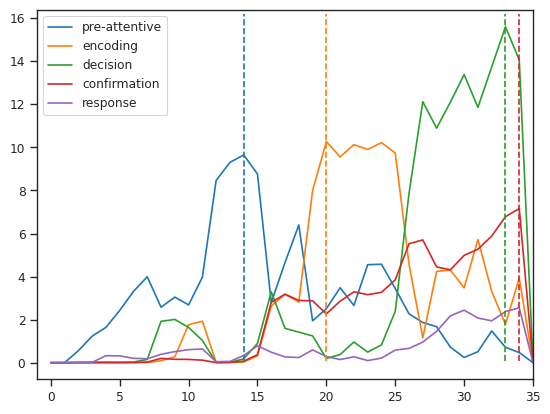

In [13]:
colors = sns.color_palette(None, n_colors=len(SAT1_STAGES_ACCURACY))
sns.set_style("ticks")
sns.set_context("paper")

nan_idx = end_idx

weights = np.sum(~np.isnan(proba_epoch), axis=1)
weights[weights == 0] = 1

# Three options
# Direct inverse
# weights = 1 / weights
# Inverse square root
weights = 1 - (1 / np.sqrt(weights))
# Combine with constant
# weights = (1 / weights + 1) / 2
predictions = np.nan_to_num(proba_epoch)
weighted_predictions = predictions * weights[:, np.newaxis, :]
weighted_avg = np.sum(weighted_predictions, axis=1)
# weighted_avg = np.sum(weighted_predictions, axis=0) / np.sum(weights, axis=0)

plt.plot(weighted_avg)
plt.xlim(-1, nan_idx)
for i in range(proba_epoch.shape[2]):
    subset = weighted_avg[:, i]
    if np.max(subset) > 0.2 * np.max(weighted_avg):
        plt.axvline(
            x=np.argmax(subset),
            ymin=0.05,
            ymax=0.99,
            color=colors[i],
            label="_nolegend_",
            linestyle="--",
        )

plt.legend(SAT1_STAGES_ACCURACY)
plt.show()

(199, 199, 5)
tensor(79)


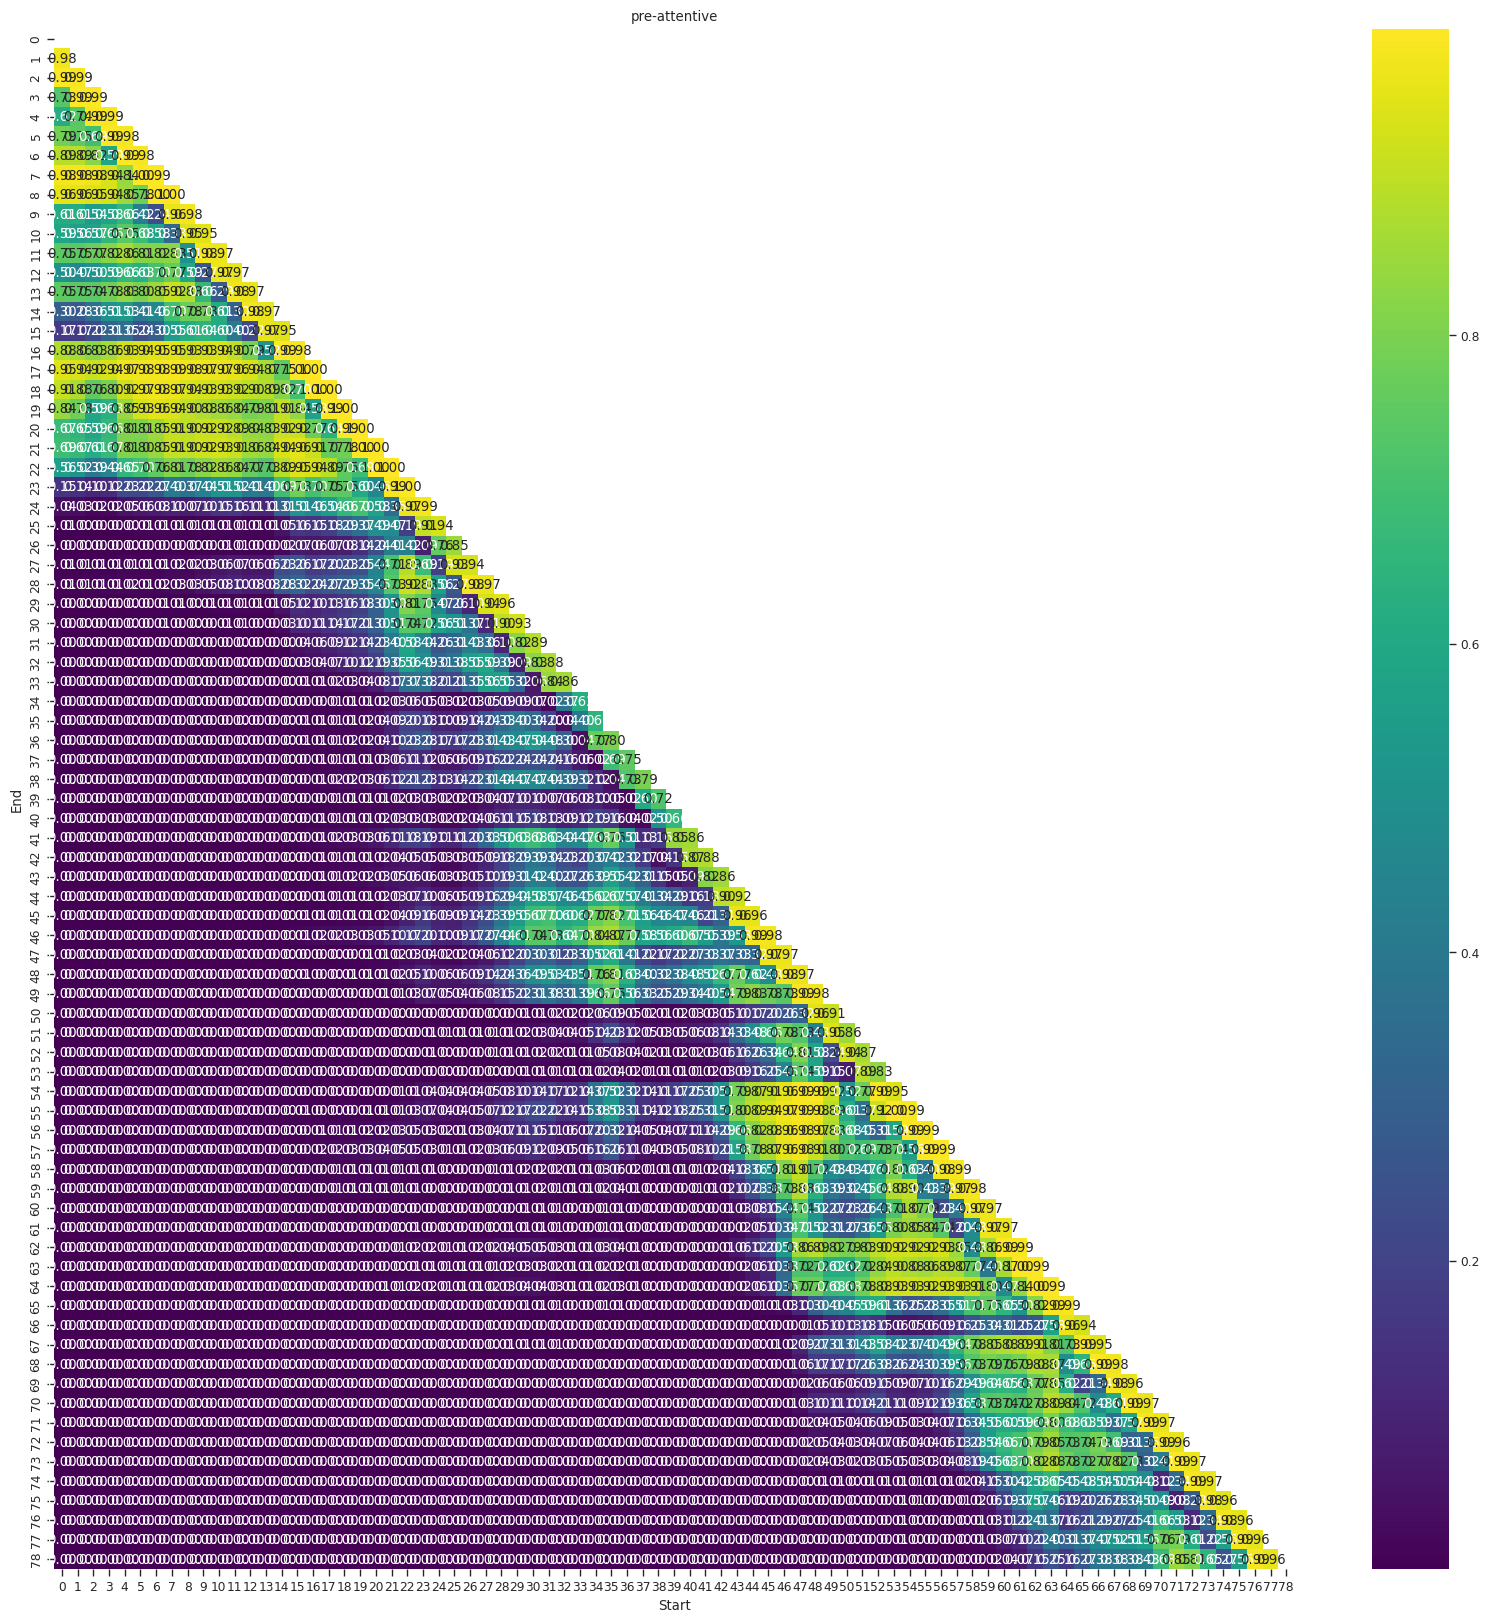

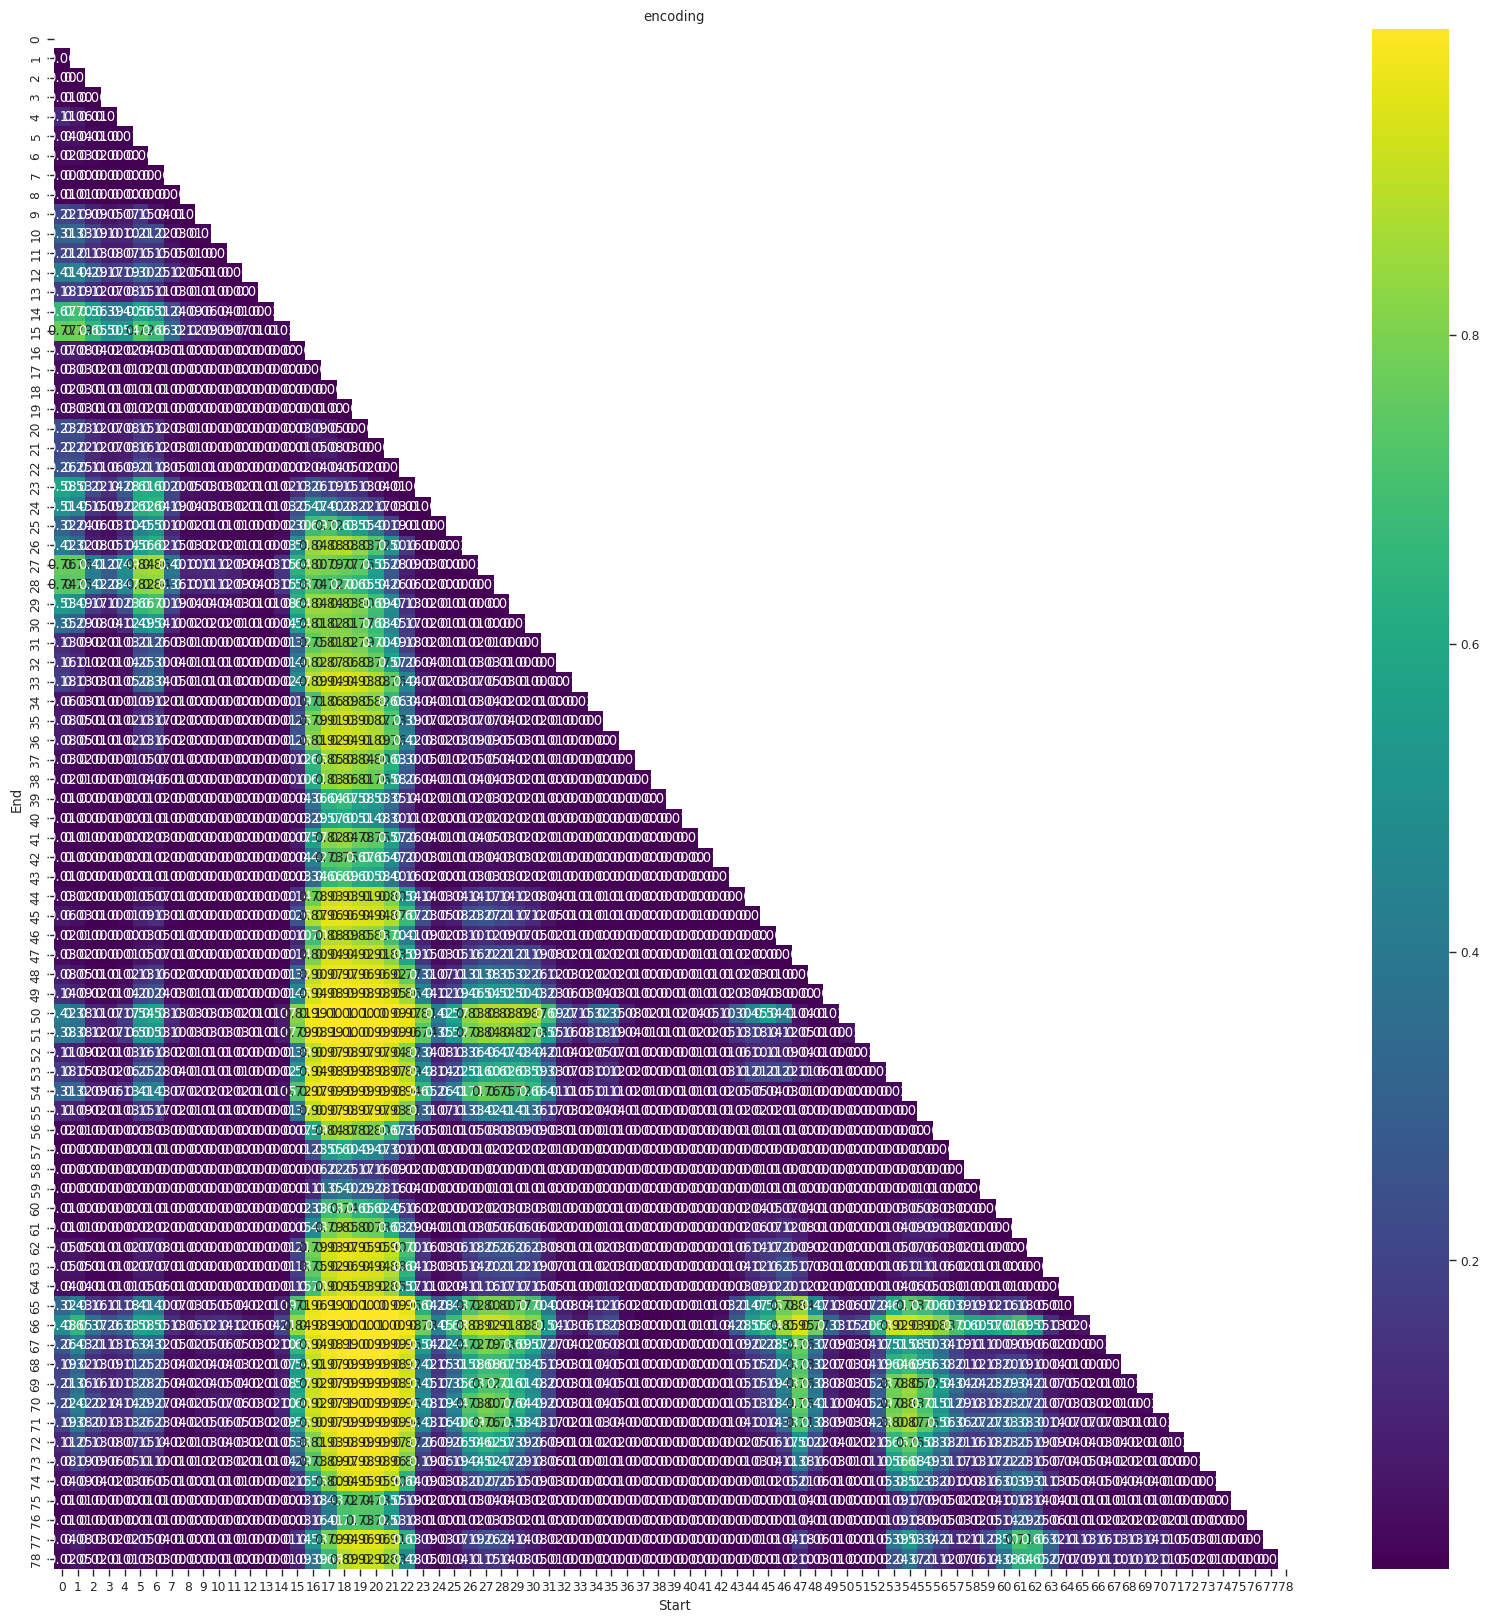

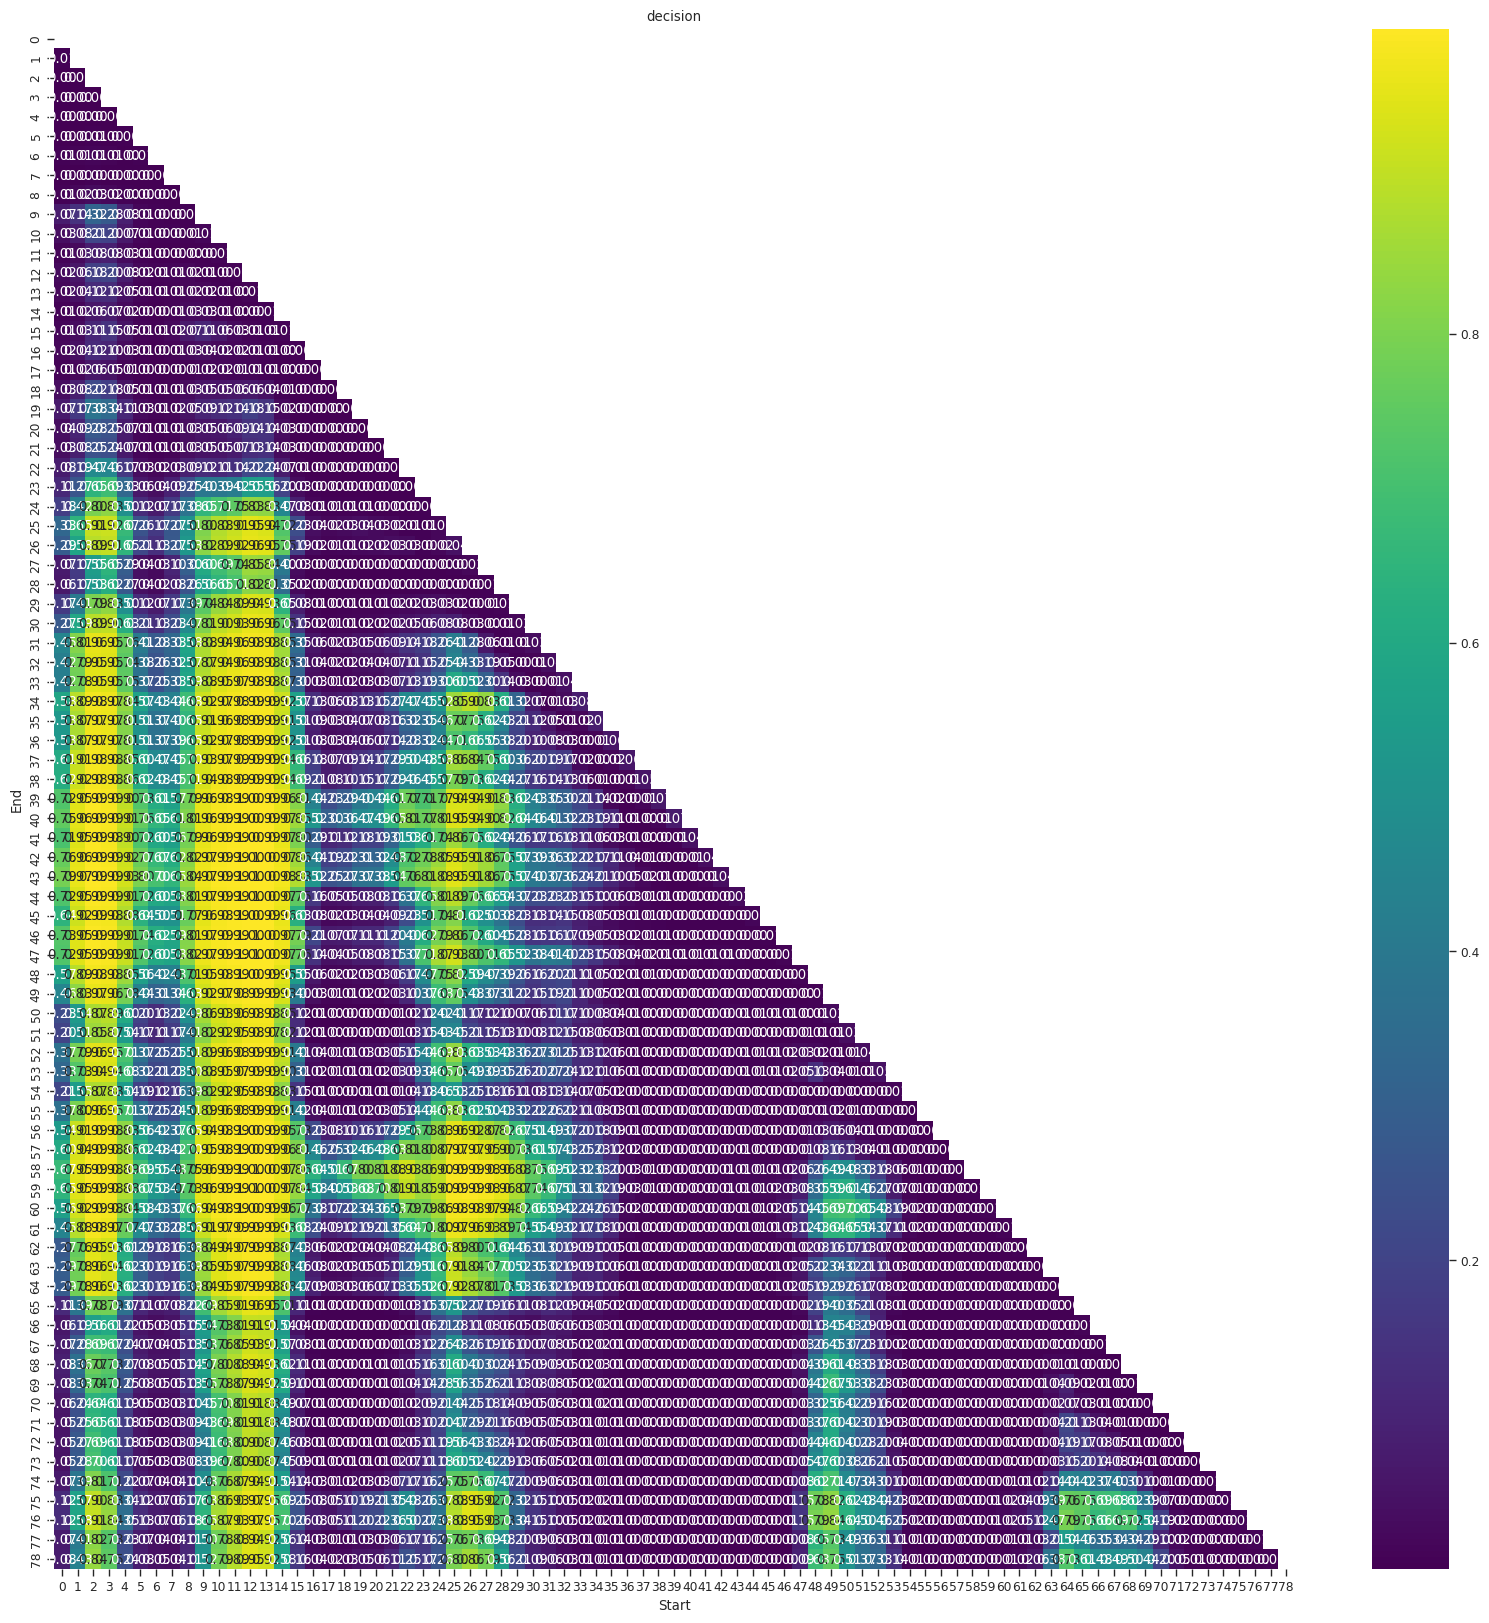

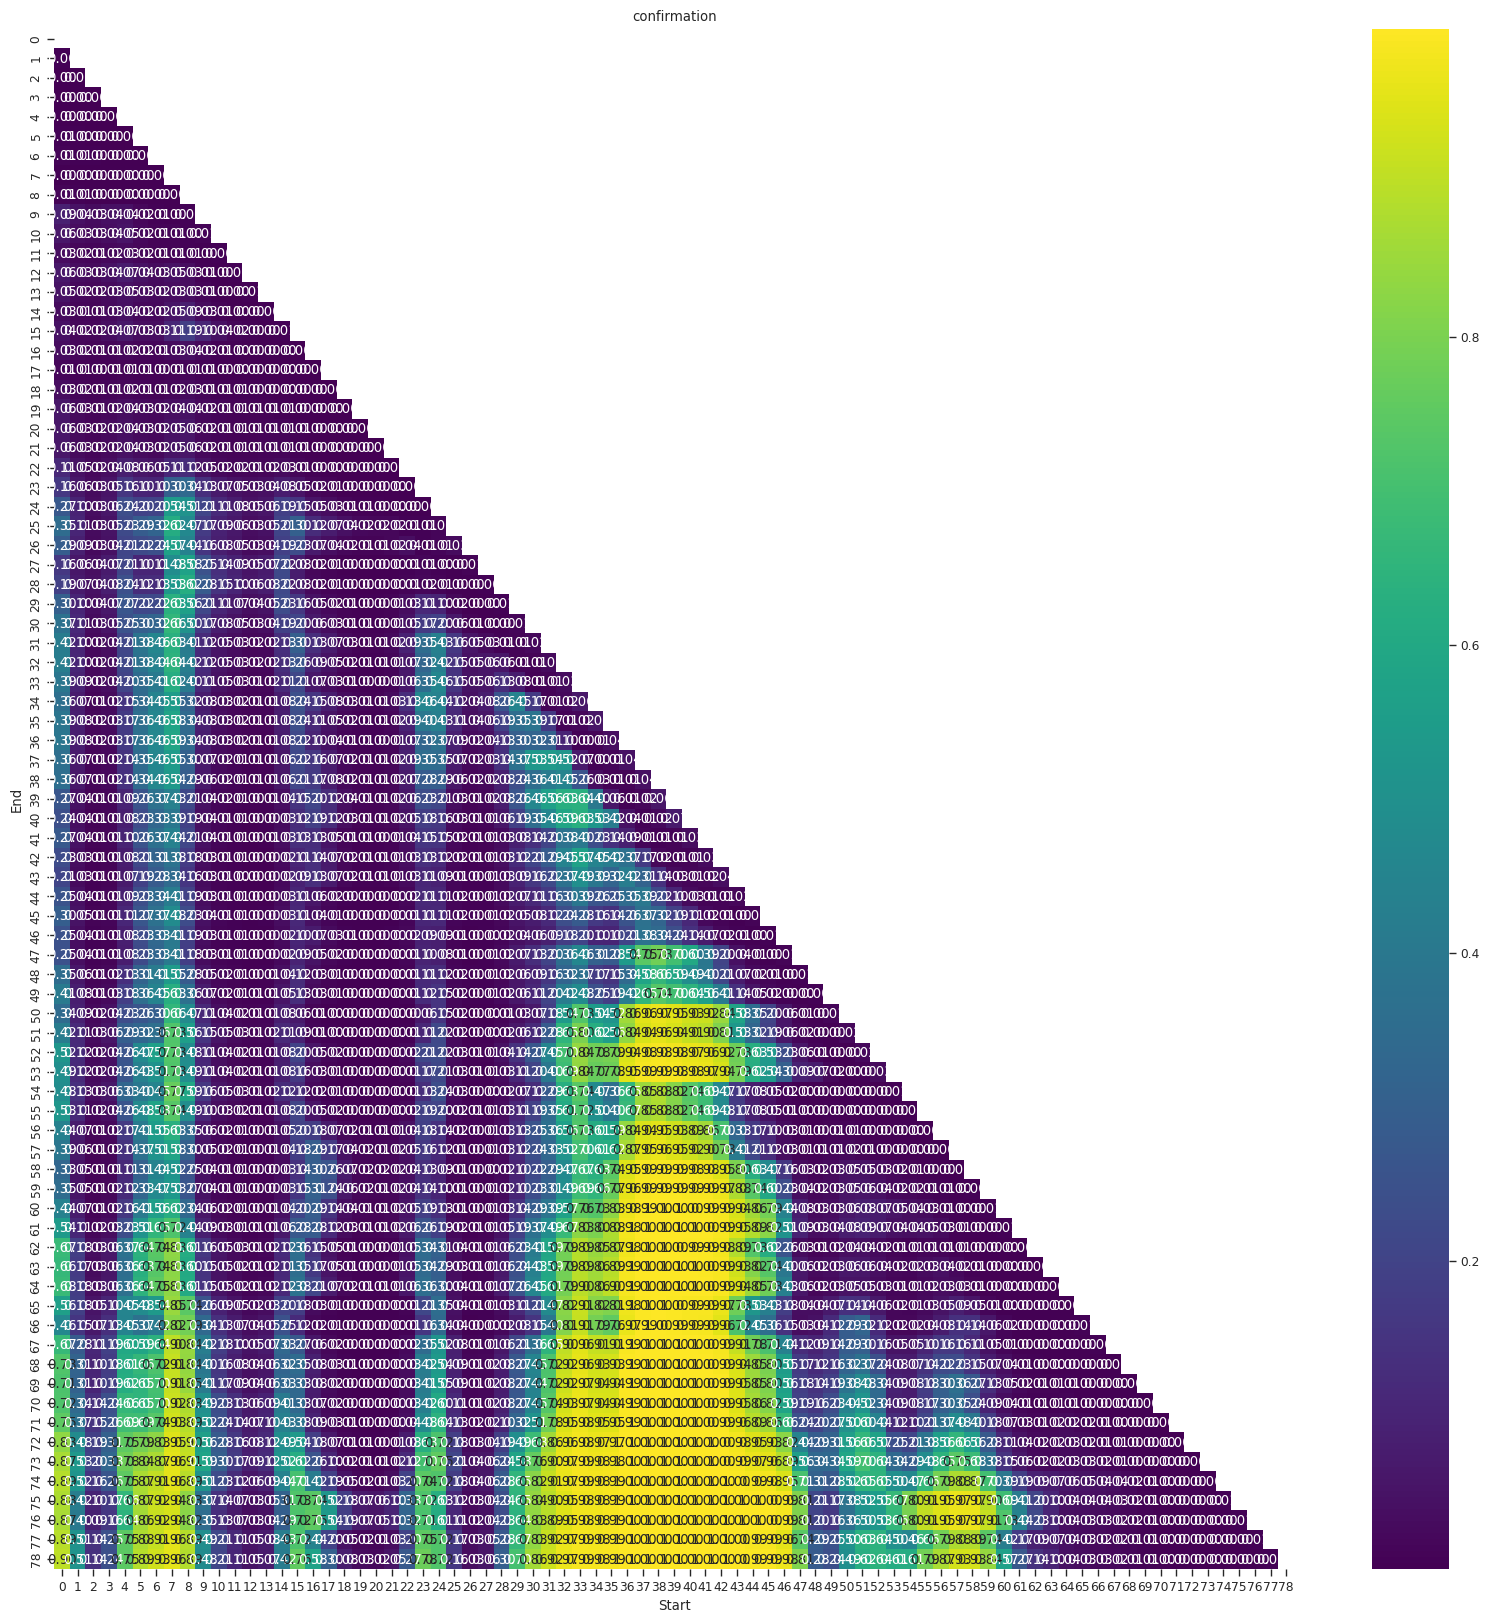

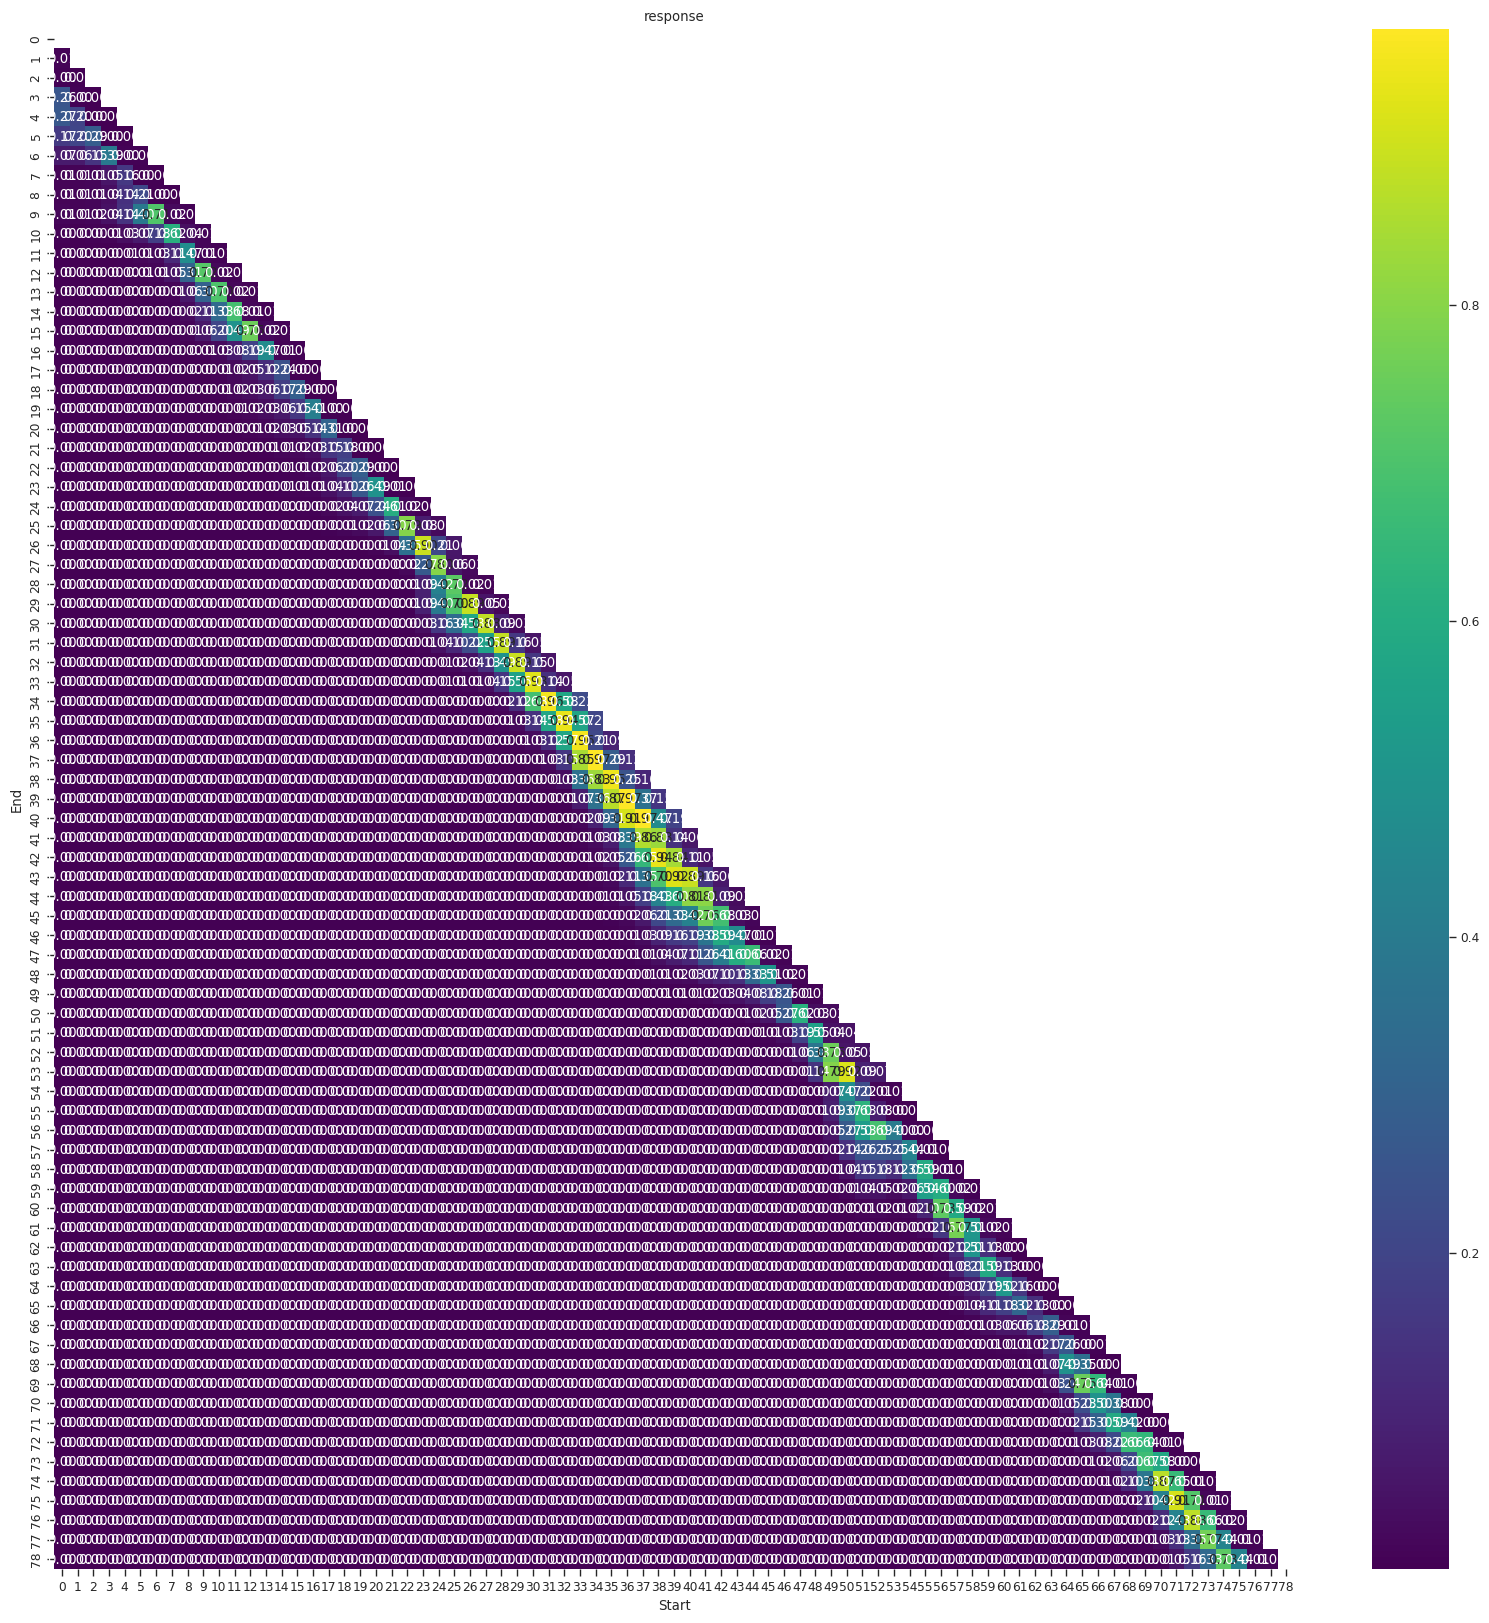

In [10]:
endrange = end_idx
heatmap_data = np.copy(proba_epoch)
# heatmap_data = np.nan_to_num(heatmap_data)
print(heatmap_data.shape)
print(endrange)
for i in range(heatmap_data.shape[2]):
    plt.figure(figsize=(20, 20))
    plt.title(SAT1_STAGES_ACCURACY[i])
    ax = sns.heatmap(
        heatmap_data[0:endrange, 0:endrange, i],
        annot=True,
        xticklabels=range(0, endrange),
        yticklabels=range(0, endrange),
        fmt=".2f",
        cmap="viridis",
    )
    # ax.xaxis.tick_top()
    # ax.yaxis.tick_right()
    # ax.xaxis.label_position = "top"
    # ax.yaxis.label_position = "right"
    # plt.xlabel("End")
    plt.xlabel("Start")
    plt.ylabel("End")
    plt.show()

In [185]:
common_labels = [
    "confirmation",
    "decision",
    "pre-attentive",
    "familiarity",
    "response",
    "memory",
    "encoding",
]

In [143]:
split_data_path_sat1 = Path("../data/sat1/split_stage_data_100hz.nc")
split_dataset_sat1 = xr.load_dataset(split_data_path_sat1)
# split_dataset_sat1["channels"] = [
#     c.upper() for c in split_dataset_sat1["channels"].values
# ]
# split_dataset_sat1 = split_dataset_sat1.reindex(channels=AR_SAT1_CHANNELS)
split_train_data, split_val_data, split_test_data = split_data_on_participants(
    split_dataset_sat1, 60, norm_min1_to_1
)

split_test_dataset = SAT1Dataset(
    split_test_data, shape_topological=shape_topological, labels=SAT1_STAGES_ACCURACY
)

split_test_loader = DataLoader(
    split_test_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

results, pred, true = test(model, split_test_loader, None)
pred = pred.cpu()

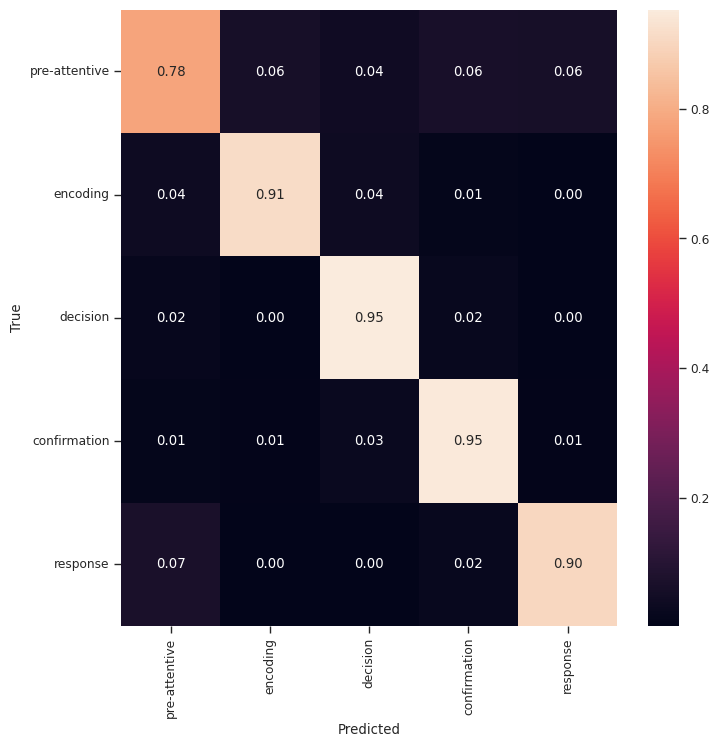

In [144]:
plot_confusion_matrix(true, pred, SAT1_STAGES_ACCURACY)